<a href="https://colab.research.google.com/github/bflaggs/DSPS_BFlaggs/blob/main/lab/inclass_Dec10_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [3]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2021-12-10 20:16:42--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2021-12-10 20:16:42--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.02s   

2021-12-10 20:16:42 (8.23 MB/s) - ‘burgers_shock.mat’ saved

(100,) (256,) (256, 100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


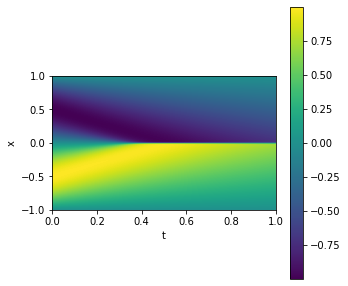

In [5]:
### what is the solution that we want? read in the data
data = scipy.io.loadmat('burgers_shock.mat')
data.keys()
t = data['t'].flatten()
x = data['x'].flatten()
Z = np.real(data['usol'])
print(t.shape, x.shape, Z.shape)
ax = pl.figure(figsize=(5,5)).add_subplot(111)
pl.imshow(Z[::-1],extent=[0,1,-1,1])
ax.set_xlabel("t")
ax.set_ylabel("x");
pl.axes().set_aspect(0.3)
pl.colorbar();


In [6]:
tf.random.set_seed(123)

In [7]:
pi = tf.constant(np.pi, dtype="float32")

In [23]:
def fun_u_0(x):
  return -tf.sin(x * pi)

def fun_u_b(t, x):
  return tf.zeros((t.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx):
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [24]:
n_b = 50
n_0 = 50
n_r = 10000
#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.


In [25]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0


<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        ,  0.9319067 ],
       [ 0.        ,  0.40087605],
       [ 0.        , -0.564904  ],
       [ 0.        , -0.86948204],
       [ 0.        , -0.56437063],
       [ 0.        , -0.58077   ],
       [ 0.        ,  0.44244576],
       [ 0.        ,  0.00857925],
       [ 0.        ,  0.47141027],
       [ 0.        , -0.8666265 ],
       [ 0.        , -0.3034687 ],
       [ 0.        , -0.46687078],
       [ 0.        , -0.3780737 ],
       [ 0.        ,  0.23899245],
       [ 0.        ,  0.01892614],
       [ 0.        , -0.39019704],
       [ 0.        ,  0.08264518],
       [ 0.        ,  0.8335893 ],
       [ 0.        , -0.87761855],
       [ 0.        ,  0.7168634 ],
       [ 0.        , -0.92907166],
       [ 0.        , -0.7528722 ],
       [ 0.        , -0.36432624],
       [ 0.        ,  0.9294741 ],
       [ 0.        , -0.1643157 ],
       [ 0.        ,  0.7618983 ],
       [ 0.        , -0.6778245 ],
      

In [26]:
u_0 = fun_u_0(x_0)
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[-0.21229336],
       [-0.9519034 ],
       [ 0.9792839 ],
       [ 0.3986406 ],
       [ 0.9796218 ],
       [ 0.9679787 ],
       [-0.983698  ],
       [-0.02694926],
       [-0.9959691 ],
       [ 0.4068518 ],
       [ 0.81537414],
       [ 0.99458873],
       [ 0.9275317 ],
       [-0.68223625],
       [-0.05942321],
       [ 0.9410903 ],
       [-0.25673023],
       [-0.49930325],
       [ 0.3750702 ],
       [-0.7767568 ],
       [ 0.22098841],
       [ 0.70069754],
       [ 0.9105302 ],
       [-0.21975516],
       [ 0.49359015],
       [-0.6801877 ],
       [ 0.8479703 ],
       [ 0.19149894],
       [ 0.9878339 ],
       [-0.41265187],
       [ 0.8647172 ],
       [ 0.95212364],
       [ 0.84135187],
       [-0.7581449 ],
       [-0.7318774 ],
       [ 0.7081403 ],
       [ 0.6880772 ],
       [-0.22325467],
       [ 0.9337654 ],
       [-0.9867025 ],
       [-0.4104546 ],
       [ 0.84358776],
       [-0.8246269 ],
     

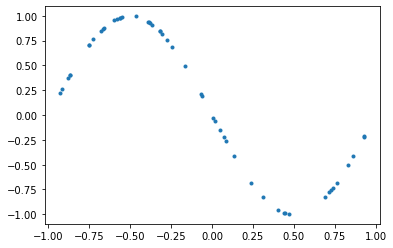

In [27]:
pl.plot(x_0, u_0, '.')

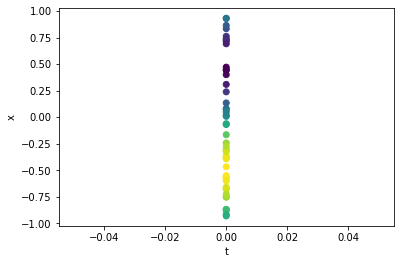

In [28]:
pl.scatter(t_0, x_0, c=u_0, marker='o')
pl.xlabel("t")
pl.ylabel("x");

In [29]:
t_b = tf.random.uniform((n_b, 1), 0, 1, dtype="float32")
t_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.50453794],
       [0.80018854],
       [0.06657732],
       [0.63224196],
       [0.3656509 ],
       [0.08347201],
       [0.81680655],
       [0.18777943],
       [0.04353368],
       [0.9307742 ],
       [0.14468765],
       [0.53515923],
       [0.07987499],
       [0.276155  ],
       [0.32227087],
       [0.07559466],
       [0.12844586],
       [0.63172746],
       [0.8620416 ],
       [0.9421437 ],
       [0.7063904 ],
       [0.01097572],
       [0.6761155 ],
       [0.969728  ],
       [0.02564728],
       [0.0946182 ],
       [0.42594278],
       [0.25619912],
       [0.17769372],
       [0.2370174 ],
       [0.02813125],
       [0.35717595],
       [0.82057834],
       [0.15759766],
       [0.37379944],
       [0.85893726],
       [0.27323818],
       [0.77470803],
       [0.972677  ],
       [0.30876338],
       [0.29690623],
       [0.43214536],
       [0.38206983],
       [0.5438458 ],
       [0.48745203],
      

In [30]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b


<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.9928107 , -1.        ],
       [ 0.8505622 , -1.        ],
       [ 0.10853839,  1.        ],
       [ 0.76495934,  1.        ],
       [ 0.12983155,  1.        ],
       [ 0.3917302 , -1.        ],
       [ 0.6040187 , -1.        ],
       [ 0.43188357,  1.        ],
       [ 0.8952024 ,  1.        ],
       [ 0.73703825, -1.        ],
       [ 0.3009684 ,  1.        ],
       [ 0.80468357,  1.        ],
       [ 0.2781657 ,  1.        ],
       [ 0.03482544,  1.        ],
       [ 0.8891907 ,  1.        ],
       [ 0.23943079,  1.        ],
       [ 0.31685317, -1.        ],
       [ 0.15409255,  1.        ],
       [ 0.60174644,  1.        ],
       [ 0.56749403,  1.        ],
       [ 0.801491  , -1.        ],
       [ 0.26008558, -1.        ],
       [ 0.15121663,  1.        ],
       [ 0.03992164,  1.        ],
       [ 0.9489281 ,  1.        ],
       [ 0.64156866, -1.        ],
       [ 0.09132087, -1.        ],
      

In [31]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

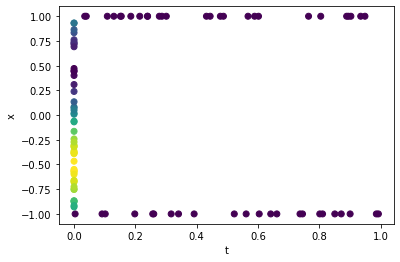

In [34]:
pl.scatter(t_b, x_b, c=u_b, marker='o')
pl.scatter(t_0, x_0, c=u_0, marker='o')
pl.xlabel("t")
pl.ylabel("x");

In [35]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.60703206,  0.47292185],
       [ 0.06531429,  0.83855534],
       [ 0.5927547 , -0.8628118 ],
       ...,
       [ 0.6859373 ,  0.52182484],
       [ 0.26668394,  0.5845585 ],
       [ 0.16582847, -0.9093933 ]], dtype=float32)>

In [37]:
nnmodel = tf.keras.Sequential()

nnomdel.add(tf.keras.Input(2))

# hidden layers
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(20, activation="tanh"))

# output layer is 1d
nnmodel.add(tf.keras.layers.Dense(1))

In [38]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss(u_pred, u_data):
  return tf.reduce_mean(tf.square(u_data - u_pred))

In [39]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

In [ ]:
history = nnmodel.fit(X, y, epochs=1000)

In [ ]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

If loss function is very spiky then I need to change my learning rate (specifically need to make it smaller). Could even do an adaptive learning rate if necessary (would need to look up how to do this).